# start

In [1]:
class Param: pass
param = Param()

#########################
param.PRFX = 'Mel0801G1'#
#########################

param.F_PSD = None 
# param.F_PSD = '../input/pubsubs/ks2019--siim-isic-notebook-0-9565-submission--ens_sub--v10--lb9565.csv'

param.PRFX_B4 = None
# param.PRFX_B4 = 'Mel0721A1'

param.ARCH = 'efficientnet-b6'

param.SZ = 512 
param.PRFX_PREP = 'MelPrp0909C512' 
# param.SZ = 384
# param.PRFX_PREP = 'MelPrp0909B384' 
# param.SZ = 224
# param.PRFX_PREP = 'MelPrp0909A224' 
param.LASTM = 3

param.BS = 12
param.SEED = 101; 

param.EPOCHS = 10

param.K=4; param.FLDS2USE = range(param.K)

param.FP16 = True

param.RandomResizedCrop_scale=(0.75, 1.0)

param.LR=3e-4
param.WD=0

param.N_SAMPL = None

param.DEBUG = False
if param.DEBUG: 
    param.FLDS2USE = range(2)
    param.N_TTA = 2
    param.EPOCHS = 3
    param.N_SAMPL = 1024

DEVICE = 'cuda'; 
if DEVICE=='cpu': param.FP16 = False
PIN_MEM = (DEVICE=='cuda'); N_WORKERS=4

param.__dict__

In [2]:
!nvidia-smi

Sat Aug 15 03:36:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   59C    P0    46W / 300W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [3]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as roc_auc

# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162#issuecomment-491115265
from PIL import ImageFile; ImageFile.LOAD_TRUNCATED_IMAGES = True

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

# import pretrainedmodels
from efficientnet_pytorch import EfficientNet
# import geffnet
import cv2
import albumentations as A
from albumentations import pytorch as AT

from apex import amp

import warnings; warnings.filterwarnings("ignore")


def sigmoid(x): return 1 / (1 + np.exp(-x))

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(param.SEED)



p_out = f'../output/{param.PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'
if param.PRFX_B4 is not None: p_b4  = f'../output/{param.PRFX_B4}'


# prep

In [4]:
p_prp = f'../output/{param.PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 
print(dftrn.shape)

if param.N_SAMPL is not None: dftrn = dftrn.sample(param.N_SAMPL)
    
display(dftrn.head(2))
display(dftrn.shape)
display(dftrn.source.value_counts())
display(dftrn.groupby('source').target.mean())

(58032, 4)


,source,im_pth,patient_id,target
0,20,../output/MelPrp0909C512/siim-isic-melanoma-cl...,IP_7279968,0.0
1,20,../output/MelPrp0909C512/siim-isic-melanoma-cl...,IP_3075186,0.0


(58032, 4)

20    32701
19    25331
Name: source, dtype: int64

source
19    0.178516
20    0.017767
Name: target, dtype: float64

## folds

In [5]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

2084


In [6]:
set_seed(param.SEED)
kf = GroupKFold(n_splits=param.K)
fld2trvl=list(kf.split(dftrn, groups=dftrn.patient_id))

for fld, (tr, vl) in enumerate(fld2trvl):
    print(fld, len(tr), len(vl))
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    assert set(dftr.patient_id)&set(dfvl.patient_id)==set()
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.target.value_counts()/len(tr))
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.source.value_counts())

0 43524 14508
1 43524 14508
2 43524 14508
3 43524 14508


0.0    0.910739
1.0    0.089261
Name: target, dtype: float64

0.0    0.911704
1.0    0.088296
Name: target, dtype: float64

0.0    0.911221
1.0    0.088779
Name: target, dtype: float64

0.0    0.914599
1.0    0.085401
Name: target, dtype: float64

20    24544
19    18980
Name: source, dtype: int64

20    24521
19    19003
Name: source, dtype: int64

20    24435
19    19089
Name: source, dtype: int64

20    24603
19    18921
Name: source, dtype: int64

In [7]:
display(dftrn.source.value_counts())
idx20 = np.where(dftrn.source==20)[0]
len(idx20)

20    32701
19    25331
Name: source, dtype: int64

32701

In [8]:
fld2vl20 = []
for tr, vl in fld2trvl:
    vl20 = np.array([o for o in vl if o in idx20])
    print(len(vl), len(vl20))
    fld2vl20.append(vl20)

14508 8157
14508 8180
14508 8266
14508 8098


## pseudo label

In [9]:
# dfpsd=pd.read_csv('../input/pubsubs/orionpax00--weighted-average-image-and-tabular--v1--submission.csv') #0.9527
if param.F_PSD:
    dftst = pd.read_csv(f'{p_prp}/test.csv') 
    dfpsd = pd.read_csv(param.F_PSD)
    dfpsd['im_pth'] = dftst.im_pth
    display(dfpsd.head(3))
    print(dfpsd.target.mean())
    plt.hist(dfpsd.target, bins=50);
    
    if param.DEBUG: dfpsd=dfpsd.head(10)

# dataset

In [10]:
class MelDataset(Dataset):
    def __init__(self, df, mode='trn'):
        self.df = df
        self.mode = mode
        if self.mode != 'trn':
            self.composed = A.Compose([
                A.Resize(param.SZ,param.SZ),
                A.Normalize(), 
                AT.ToTensor(),
            ]) 
        else:
            self.composed = A.Compose([
                A.RandomResizedCrop(param.SZ,param.SZ, scale=param.RandomResizedCrop_scale),
                A.Transpose(),
                A.Flip(),
                A.Rotate(360),
                A.OneOf([A.RandomBrightnessContrast(), A.CLAHE(),]),
                A.HueSaturationValue(hue_shift_limit=3, sat_shift_limit=3),
                A.OneOf([A.Blur(blur_limit=2), A.IAASharpen()]),
                A.Normalize(), 
                AT.ToTensor(),
            ])    
    def __getitem__(self, i):
        x = cv2.imread(self.df.im_pth.values[i]) 
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = self.composed(image=x)['image']
        if self.mode !='tst':
            y = self.df.target.values[i]
            return x, y
        else:
            return (x,)
    
    def __len__(self):
        return len(self.df)    

In [11]:
if param.DEBUG: 
    dstrn = MelDataset(dftrn, mode='trn')
    i = np.random.choice(len(dstrn))
    print(dstrn[i][0].shape)

In [12]:
# better comment out A.Normalize() when showing 
if param.DEBUG:
    plt.imshow(dstrn[i][0].permute(1, 2, 0))

# model

In [13]:
def mkmdl():  
    mdl = EfficientNet.from_pretrained(param.ARCH, num_classes=1)
    return mdl

## focal loss

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=3, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

def loss_fn(outputs, targets):
    return FocalLoss()(outputs, targets.view(-1, 1))

# train

## TTA

In [15]:
def evaluate(model, dl):
    model.eval()
    prd=[]
    y=[]
    for step, dat in enumerate(dl):
        xb, yb = (o.to(device) for o in dat)
        with torch.no_grad(): prdb = model(xb)
        prd.append(prdb.cpu().detach().numpy())
        y.append(yb.cpu().detach().numpy())
    prd = np.concatenate(prd)    
    y = np.concatenate(y)    
    lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
    scr = roc_auc(y, prd)
    return lss, scr, y, prd

## infer

In [16]:
# def infer(model, dl):
#     model.eval()
#     prd=[]
#     for i in range(param.N_TTA):
#         prdi = []
#         for step, dat in enumerate(dl):
#             xb=dat[0].to(device)
#             with torch.no_grad(): 
#                 prdb = model(xb)
#             prdi.append(prdb.cpu().detach().numpy())
#         prdi = np.concatenate(prdi)    
#         prd.append(prdi)
#     prd = np.mean(prd, 0)
#     return prd

In [17]:
def infer(model, dl):
    lendl=len(dl)
    model.eval()
    prd = []
    for step, dat in enumerate(dl):
        xb=dat[0].to(device)
        with torch.no_grad(): prdb = model(xb)
        prd.append(prdb.cpu().detach().numpy())
    prd = np.concatenate(prd)    
    return prd

## set up data

In [18]:
def getdls(fld):
    tr,vl=fld2trvl[fld]
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    ystr=dftr.target.values
    ysvl=dfvl.target.values
    cols2use=['im_pth', 'target']
    if param.F_PSD is not None:
        dftr= pd.concat([dftrn[cols2use].iloc[tr], dfpsd[cols2use]])
    dstr = MelDataset(dftr, mode='trn')
    dsvl = MelDataset(dfvl, mode='val')
    dltr = DataLoader(dstr, batch_size=param.BS,   shuffle=True,  num_workers=N_WORKERS, pin_memory=PIN_MEM)
    dlvl = DataLoader(dsvl, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
    return dltr,dlvl

## run train

In [19]:
set_seed(param.SEED)

results = {}
results['fld2trvl'] = fld2trvl
results['param'] = param
results['fld2stats']={}

# results =  pickle.load(open(f'{p_out}/results_{param.PRFX}.p', 'rb'))  


In [20]:
for fld in param.FLDS2USE:    
    tr,vl=fld2trvl[fld]
    dltr,dlvl=getdls(fld)
    print(f'fld:{fld};', 'dltr,dlvl:', len(dltr), len(dlvl))

    mdl = mkmdl().to(device)
    if param.PRFX_B4 is not None: 
        fnm_mdl_b4 = f'{p_b4}/model_{param.PRFX_B4}_fld_{fld}_best.p'
        print('load previously trained', fnm_mdl_b4)
        mdl.load_state_dict(torch.load(fnm_mdl_b4, map_location=torch.device(DEVICE)))
    opt = optim.Adam(mdl.parameters(), lr=param.LR, weight_decay=param.WD)
#     schdl = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=param.PLTFACTOR, patience=param.PATIENCE, min_lr=param.MIN_LR, verbose=True)
    schdl = optim.lr_scheduler.OneCycleLR(opt, max_lr=param.LR, total_steps=param.EPOCHS*len(dltr))
    if param.FP16: mdl, opt = amp.initialize(mdl, opt, opt_level='O1', verbosity=0)
    mdl.zero_grad()


    stats = {
    'lss': {'tr':[],'vl':[],},
    'scr': {'tr':[],'vl':[],},
    }
    ep2oof = []
    best_scr = float('-inf')
    best_epc = -1    
    
    for epc in range(param.EPOCHS):
        prdtr_ep=[]
        ytr_ep=[]
        for step, dat in enumerate(dltr):
            mdl.train()
            xb,yb=(o.to(device) for o in dat)
            yb = yb.unsqueeze(1)
            prdb = mdl(xb)
    #         loss = F.binary_cross_entropy_with_logits(prdb, yb)
            loss =  loss_fn(prdb,yb)
            if param.FP16:
                with amp.scale_loss(loss, opt) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            if param.FP16:
                torch.nn.utils.clip_grad_norm_(amp.master_params(opt), 1)
            else:
                torch.nn.utils.clip_grad_norm_(mdl.parameters(), 1)
            opt.step()
            opt.zero_grad()
            prdtr_ep.append(prdb.cpu().detach().numpy())
            ytr_ep.append(yb.cpu().detach().numpy())
            if step>0 and step%1000==0: print(dtnow(), f'ep {epc} step {step}/{len(dltr)}')

        prdtr_ep = np.concatenate(prdtr_ep)
        ytr_ep = np.concatenate(ytr_ep)    
        lss_tr_ep = F.binary_cross_entropy_with_logits(torch.tensor(prdtr_ep),torch.tensor(ytr_ep)).item()
        scr_tr_ep = roc_auc(ytr_ep>=0.5, prdtr_ep)
        stats['lss']['tr'].append(lss_tr_ep)
        stats['scr']['tr'].append(scr_tr_ep)

        lss_vl_ep, scr_vl_ep, yvl_ep, prdvl_ep = evaluate(mdl, dlvl)
        stats['lss']['vl'].append(lss_vl_ep)
        stats['scr']['vl'].append(scr_vl_ep)
        ep2oof.append(prdvl_ep)

        print(dtnow(), f'fld {fld} ep {epc}: lss_tr {lss_tr_ep:.3f}; lss_vl {lss_vl_ep:.3f}; scr_tr {scr_tr_ep:.3f}; scr_vl {scr_vl_ep:.3f}; ')
        torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_epc_{epc}.p')

#         prdtst = infer(mdl, dltst)
#         dfsub.target = sigmoid(prdtst)
#         dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv', index=False)

        if scr_vl_ep>best_scr:
            print(f'better scr {best_scr:.3f} -> {scr_vl_ep:.3f}')
            best_scr = scr_vl_ep
            best_epc = epc
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_best.p')
#             dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best.csv', index=False)

        schdl.step(scr_vl_ep)  # Update learning rate schedule
        
        stats['best_scr'] = best_scr
        stats['best_epc'] = best_epc
        results['fld2stats'][fld] = stats
        pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))  
    del mdl,opt,schdl
    gc.collect()            
    pickle.dump(ep2oof, open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'wb'))  

fld:0; dltr,dlvl: 3627 605
Loaded pretrained weights for efficientnet-b6
2020-08-15 03:47:43 ep 0 step 1000/3627
2020-08-15 03:58:27 ep 0 step 2000/3627
2020-08-15 04:09:11 ep 0 step 3000/3627
2020-08-15 04:17:46 fld 0 ep 0: lss_tr 0.408; lss_vl 0.371; scr_tr 0.824; scr_vl 0.895; 
better scr -inf -> 0.895
2020-08-15 04:28:54 ep 1 step 1000/3627
2020-08-15 04:39:40 ep 1 step 2000/3627
2020-08-15 04:50:31 ep 1 step 3000/3627
2020-08-15 04:59:19 fld 0 ep 1: lss_tr 0.352; lss_vl 0.345; scr_tr 0.893; scr_vl 0.908; 
better scr 0.895 -> 0.908
2020-08-15 05:10:20 ep 2 step 1000/3627
2020-08-15 05:21:10 ep 2 step 2000/3627
2020-08-15 05:31:57 ep 2 step 3000/3627
2020-08-15 05:40:33 fld 0 ep 2: lss_tr 0.328; lss_vl 0.326; scr_tr 0.912; scr_vl 0.918; 
better scr 0.908 -> 0.918
2020-08-15 05:51:23 ep 3 step 1000/3627
2020-08-15 06:02:16 ep 3 step 2000/3627
2020-08-15 06:13:11 ep 3 step 3000/3627
2020-08-15 06:21:56 fld 0 ep 3: lss_tr 0.314; lss_vl 0.326; scr_tr 0.922; scr_vl 0.924; 
better scr 0.9

2020-08-16 06:40:34 ep 5 step 3000/3627
2020-08-16 06:50:53 fld 3 ep 5: lss_tr 0.288; lss_vl 0.266; scr_tr 0.938; scr_vl 0.932; 
better scr 0.926 -> 0.932
2020-08-16 07:04:12 ep 6 step 1000/3627
2020-08-16 07:18:10 ep 6 step 2000/3627
2020-08-16 07:31:25 ep 6 step 3000/3627
2020-08-16 07:41:37 fld 3 ep 6: lss_tr 0.275; lss_vl 0.271; scr_tr 0.947; scr_vl 0.928; 
2020-08-16 07:54:53 ep 7 step 1000/3627
2020-08-16 08:08:15 ep 7 step 2000/3627
2020-08-16 08:22:19 ep 7 step 3000/3627
2020-08-16 08:32:33 fld 3 ep 7: lss_tr 0.262; lss_vl 0.256; scr_tr 0.953; scr_vl 0.924; 
2020-08-16 08:46:05 ep 8 step 1000/3627
2020-08-16 09:00:02 ep 8 step 2000/3627
2020-08-16 09:13:13 ep 8 step 3000/3627
2020-08-16 09:23:19 fld 3 ep 8: lss_tr 0.249; lss_vl 0.234; scr_tr 0.958; scr_vl 0.931; 
2020-08-16 09:36:46 ep 9 step 1000/3627
2020-08-16 09:50:03 ep 9 step 2000/3627
2020-08-16 10:03:23 ep 9 step 3000/3627
2020-08-16 10:13:43 fld 3 ep 9: lss_tr 0.239; lss_vl 0.233; scr_tr 0.962; scr_vl 0.928; 


In [21]:
pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))  

# training trajec

In [22]:
for fld,stats in results['fld2stats'].items():
    print(f"fld {fld} best_epc: {stats['best_epc']}; best_scr: {stats['best_scr']:.4f};")

fld 0 best_epc: 5; best_scr: 0.9305;
fld 1 best_epc: 5; best_scr: 0.9353;
fld 2 best_epc: 8; best_scr: 0.9299;
fld 3 best_epc: 5; best_scr: 0.9316;


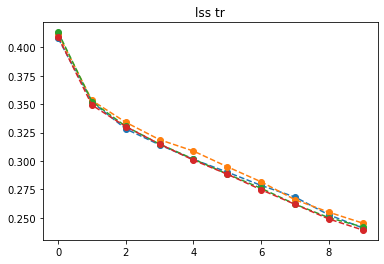

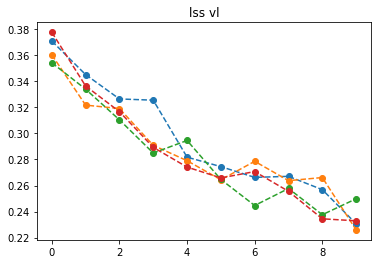

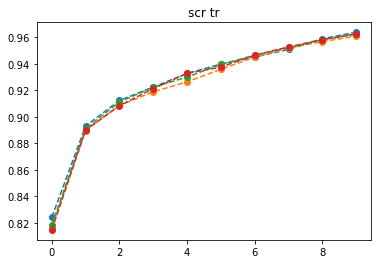

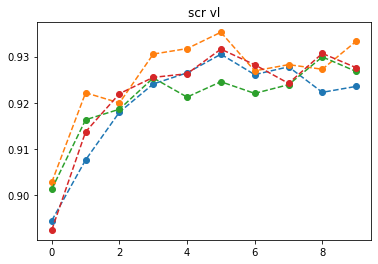

In [23]:
for mtrc in ['lss', 'scr']:
    for k in ['tr','vl',]:
        plt.title(f'{mtrc} {k}')
        for fld in param.FLDS2USE:
            plt.plot(results['fld2stats'][fld][mtrc][k], 'o--')
        plt.show()

# oofs

In [24]:
vls = []
for fld in param.FLDS2USE:
    _,vl=fld2trvl[fld]
    vls += list(vl)
len(vls), vls[:10]

(58032, [0, 1, 4, 6, 10, 15, 17, 19, 21, 29])

## only last epoch 

In [25]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:,-1])
    oofs += list(oof)
    
roc_auc(dftrn.target.iloc[vls], oofs)

0.9272799595649982

In [26]:
roc_auc(dftrn.target.iloc[[o for o in vls if o in idx20]],
        [o[0] for o in zip(oofs,vls) if o[1] in idx20])

0.9127558177917148

## only best_scr epoch

In [27]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    best_epc = results['fld2stats'][fld]['best_epc']
    oof = list(ep2oof[:,best_epc])
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9311113930842106

In [28]:
roc_auc(dftrn.target.iloc[[o for o in vls if o in idx20]],
        [o[0] for o in zip(oofs,vls) if o[1] in idx20])

0.9140608689874244

## avg last m epochs

In [29]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:, -3:].mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9300250043422412

In [30]:
roc_auc(dftrn.target.iloc[[o for o in vls if o in idx20]],
        [o[0] for o in zip(oofs,vls) if o[1] in idx20])

0.9172586717623028

In [31]:
def get_oof_avg_last_m(m):
    oofs = []
    for fld in param.FLDS2USE:
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
        ep2oof = np.concatenate(ep2oof,1)
        oof = list(ep2oof[:, param.EPOCHS-m:param.EPOCHS].mean(1))
        oofs += list(oof)
    return oofs

In [32]:
for m in range(1,param.EPOCHS+1):
    oofs = get_oof_avg_last_m(m)
    oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
    print(m, f'{roc_auc(dftrn.target.iloc[vls], oofs):.4f}', )

1 0.9273
2 0.9297
3 0.9300
4 0.9305
5 0.9319
6 0.9323
7 0.9327
8 0.9327
9 0.9328
10 0.9327


In [33]:
for m in range(1, param.EPOCHS+1):
    oofs = get_oof_avg_last_m(m)
    oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
    auc20=roc_auc(dftrn.target.iloc[[o for o in vls if o in idx20]],
        [o[0] for o in zip(oofs,vls) if o[1] in idx20])
    print(m, f'{auc20:.4f}')


1 0.9128
2 0.9163
3 0.9173
4 0.9174
5 0.9184
6 0.9178
7 0.9169
8 0.9161
9 0.9153
10 0.9141


# Inference

In [34]:
dftst = pd.read_csv(f'{p_prp}/test.csv', nrows=128 if param.DEBUG else None) 
display(dftst.head(3))

dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv', nrows=128 if param.DEBUG else None) 

dstst = MelDataset(dftst, mode='tst')
print(len(dstst))
dltst = DataLoader(dstst, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltst))
lendl=len(dltst)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../output/MelPrp0909C512/siim-isic-melanoma-cl...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../output/MelPrp0909C512/siim-isic-melanoma-cl...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../output/MelPrp0909C512/siim-isic-melanoma-cl...


10982
458


In [35]:
# avg last m epochs
mdl = mkmdl().to(device)
for fld in param.FLDS2USE:
    for epc in range(param.EPOCHS-param.LASTM, param.EPOCHS):
        mdl.load_state_dict(torch.load(f'{p_out}/model_{param.PRFX}_fld_{fld}_epc_{epc}.p'))
        prdtst = infer(mdl, dltst)
        dfsub.target = sigmoid(prdtst)
        dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv', index=False)
        print(dtnow(), f'fld {fld} ep {epc}', f'{dfsub.target.mean():.4f}')


Loaded pretrained weights for efficientnet-b6
2020-08-16 10:15:45 fld 0 ep 7 0.1646
2020-08-16 10:17:09 fld 0 ep 8 0.1692
2020-08-16 10:18:33 fld 0 ep 9 0.1736
2020-08-16 10:19:57 fld 1 ep 7 0.1983
2020-08-16 10:21:21 fld 1 ep 8 0.1783
2020-08-16 10:22:44 fld 1 ep 9 0.1965
2020-08-16 10:24:09 fld 2 ep 7 0.1829
2020-08-16 10:25:33 fld 2 ep 8 0.1988
2020-08-16 10:26:56 fld 2 ep 9 0.1841
2020-08-16 10:28:19 fld 3 ep 7 0.2004
2020-08-16 10:29:43 fld 3 ep 8 0.1976
2020-08-16 10:31:06 fld 3 ep 9 0.1944


fld 0 epc 7 0.1646
fld 0 epc 8 0.1692
fld 0 epc 9 0.1736
fld 1 epc 7 0.1983
fld 1 epc 8 0.1783
fld 1 epc 9 0.1965
fld 2 epc 7 0.1829
fld 2 epc 8 0.1988
fld 2 epc 9 0.1841
fld 3 epc 7 0.2004
fld 3 epc 8 0.1976
fld 3 epc 9 0.1944

0.18655439751974595


,image_name,target
0,ISIC_0052060,0.168327
1,ISIC_0052349,0.059182
2,ISIC_0058510,0.047147


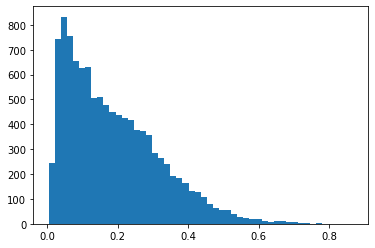

In [36]:
lst_sub = []
for fld in param.FLDS2USE:
    for epc in range(param.EPOCHS-param.LASTM, param.EPOCHS):
        sub_fld_epc = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv') 
        print('fld', fld, 'epc', epc, f'{sub_fld_epc.target.mean():.4f}')
        lst_sub.append(sub_fld_epc.target.values)
print()
sub = np.mean(lst_sub, 0)
print(sub.mean())
dfsub.target = sub

display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [37]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_avglast{param.LASTM}.csv', index=False)

# fin

In [38]:
param.__dict__

{'PRFX': 'Mel0801G1',
 'F_PSD': None,
 'PRFX_B4': None,
 'ARCH': 'efficientnet-b6',
 'SZ': 512,
 'PRFX_PREP': 'MelPrp0909C512',
 'LASTM': 3,
 'BS': 12,
 'SEED': 101,
 'EPOCHS': 10,
 'K': 4,
 'FLDS2USE': range(0, 4),
 'FP16': True,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'LR': 0.0003,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [39]:
!nvidia-smi

Sun Aug 16 10:31:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   67C    P0    67W / 300W |  15774MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  